# Python Tutorial - Model Interpretability
Explainable artificial intelligence (XAI) helps you understand and interpret "black box" model predictions. This tutorial provides an overview of model interpretability and popular off-the-shelf methods to use in your own ML frameworks.

We will review the following interpretability methods in this tutorial. This is not an exhuastive list, but these are some of the most popular.

1. Model-Based Feature Importance
2. Global Surrogate
3. Local Interpretable Model-Agnostic Explanations (LIME)
4. Shapley Additive exPlanations (SHAP)

***Please make a copy of this notebook to make your own edits in Google Colab.***

### [1] Model-Based Feature Importance

Model-based feature importance uses the model directly to assess the importance of individual importance in a model.

**Examples**
*   Gini Importance in Decision Trees/Random Forests
*   Coefficients in Linear Regression

### [2] Global Surrogate

The global surrogate method of model interpretability approximates a complicated, black-box model output by creating a simplier, more interpretable model. These are particularly useful when complex models are being used, such as deep neural networks.

**Examples**
 * Black-Box Random Forest Classifier with Surrogate Decision Tree
 * Black-Box Neural Network with Surrogate Linear Regression


### [3] LIME
Local Interpretable Model-Agnostic Explanations (LIME) is a model-agnostic method for explaining the results of any complex, black-box model. It does this by providing a global understanding of the model by explaining a set of individual predictions.

Paper: https://www.kdd.org/kdd2016/papers/files/rfp0573-ribeiroA.pdf

Github: https://github.com/marcotcr/lime

### [4] SHAP
SHapley Additive exPlanations (SHAP) is another model-agnostic method for explaining the output of a ML model. It works by borrowing characteristcs from game theroy and calculating the fair contribution of each feature to a model's prediction.

Paper: https://www.jmlr.org/papers/volume11/strumbelj10a/strumbelj10a.pdf

SHAP: https://www.nature.com/articles/s42256-019-0138-9.epdf?shared_access_token=RCYPTVkiECUmc0CccSMgXtRgN0jAjWel9jnR3ZoTv0O81kV8DqPb2VXSseRmof0Pl8YSOZy4FHz5vMc3xsxcX6uT10EzEoWo7B-nZQAHJJvBYhQJTT1LnJmpsa48nlgUWrMkThFrEIvZstjQ7Xdc5g%3D%3D

Github: https://github.com/slundberg/shap#citations

## Hands-on Python Tutorial
This section of the tutorial demostrates how to apply LIME and SHAP on a synthetic dataset.


### [1] Setup & Installation

In [ ]:
# Install Libraries
!pip install lime
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=249beca794d9e1926a3940f35ebec9d1215970b745c18e353b24c9d5758ced1e
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.9 MB/s eta 0:00:00


In [ ]:
# Load Libraries
import warnings
import numpy as np
import pandas as pd
import random
from random import choices
from sklearn.model_selection import KFold
import xgboost as xgb
import lime.lime_tabular
from lime import submodular_pick
import shap
import matplotlib.pyplot as plt

### [2] Create Synthetic Dataset

Before we can practice using LIME and SHAP, we need a dataset to work with. In this section, we will create a synthetic dataset. We will manually set the weights of 20 features and their respective values for 2000 datapoints.

In [ ]:
# Dataset Generation Function
def create_dataset(n_positive,n_negative,n_irrelevant,n_sample):
    random.seed(461)
    create_dict = {}

    positive_weight = list(range(1,n_positive+1))
    negative_weight = list(range(1,n_negative+1))
    negative_weight = [-1*weight for weight in negative_weight]
    irrelevant_weight = [0]*n_irrelevant
    weight_list = positive_weight+negative_weight+irrelevant_weight

    for n_iter in range(n_positive):
        positive_feature = choices(list(range(0,n_positive*10)),k=n_sample)
        create_dict["positive_"+str(n_iter+1)] = positive_feature

    for n_iter in range(n_negative):
        negative_feature = choices(list(range(0,n_negative*10)),k=n_sample)
        create_dict["negative_"+str(n_iter+1)] = negative_feature

    for n_iter in range(n_irrelevant):
        irrelevant_feature = choices(list(range(0,n_irrelevant*10)),k=n_sample)
        create_dict["irrelevant_"+str(n_iter+1)] = irrelevant_feature

    df_feature = pd.DataFrame(create_dict)

    target_list = []
    for idx in range(len(df_feature)):
        target_list.append(np.sum(np.multiply(df_feature.loc[idx].values,np.array(weight_list))))

    threshold = np.median(target_list)
    df_target = pd.DataFrame({"target_variable":target_list})

    return df_feature,df_target

In [ ]:
# Synthetic Dataset Parameters
n_positive = 2        # 2 Positive Features
n_negative = 2        # 2 Negative Features
n_irrelevant = 16     # 16 Irrelevant Features
n_sample = 2000       # 2000 Data Points

# Generate Dataset
df_feature,df_target = create_dataset(n_positive,n_negative,n_irrelevant,n_sample)

In [ ]:
'''

df_feature: 2000 Data Points x 20 Features
  - Represents the "raw data" for each data point and feature.
  - 'positive_1', 'positive_2', 'negative_1', and 'negative_2'  range in value between 1-20.
  - All 16 irrelevant features range in value between 1-160.
  - Positive features have positive weight W.
  - Negative features have negative weight W.
  - Irrelevant features have zero weight.

df_target: 2000 samples x 1 Target
 - target = positive_1*1 + positive_2*2 + negative_1*-1 + negative_2*-2
 - 'positve_2' has weight 2, 'positive_1' has weight 1, 'negative_2' has weight -2, and 'negative_1' has weight -1
 - All irrelavent features have a weight of 0, therefore they are not included in the target calculation.

'''

display(df_feature.head(5))
display(df_target.head(5))

,positive_1,positive_2,negative_1,negative_2,irrelevant_1,irrelevant_2,irrelevant_3,irrelevant_4,irrelevant_5,irrelevant_6,irrelevant_7,irrelevant_8,irrelevant_9,irrelevant_10,irrelevant_11,irrelevant_12,irrelevant_13,irrelevant_14,irrelevant_15,irrelevant_16
0,14,3,17,1,119,64,155,106,29,19,71,31,77,126,79,152,94,50,10,6
1,15,13,13,16,125,78,66,19,134,76,68,137,136,37,146,126,51,94,79,94
2,11,18,19,13,84,30,114,95,124,23,81,53,58,41,52,130,101,31,69,113
3,10,11,13,18,49,22,36,12,91,23,157,1,58,156,66,77,137,97,81,8
4,18,7,0,6,72,72,144,23,150,47,86,50,2,158,92,118,87,5,151,62


,target_variable
0,1
1,-4
2,2
3,-17
4,20


### [3] Train-Test Split

In this section, we are going to apply 10-fold cross validation on our synthetic dataset.

In [ ]:
# Convert Pandas Array to Numpy Array
X = df_feature.values
y = df_target.values.reshape(-1)

# Apply Test/Train Split
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    break

### [4] XGBoost Regressor

In this section, we will conduct regression using XGBoost.

In [ ]:
# Call XGBoost Regressor
model=xgb.XGBRegressor(random_state=461)      # Initialize the Model
model.fit(X_train, y_train)                   # Train the Model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=461, ...)

In [ ]:
# Print First Predicted Value
print("1st Predicted Value:",model.predict(X_test)[0])
print("1st True Value:",y_test[0])

1st Predicted Value: -1.3345392
1st True Value: 1


### [5] LIME Explanation

Using the outputs of the first predicted value from XGBoost, in this section we will use LIME to help interpret our results.

In [ ]:
# Call LIME Explainer Function
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=df_feature.columns, class_names=['target'], mode='regression')

In [ ]:
# Visualize First Prediction's Explanation
i = 0
instance_explainer = explainer.explain_instance(X_test[i], model.predict, num_features=10)
instance_explainer.show_in_notebook(show_table=True, show_predicted_value=False)

In the above output, LIME creates multiple feature bins to explain the direction and magnitude of influence on just the first prediction.

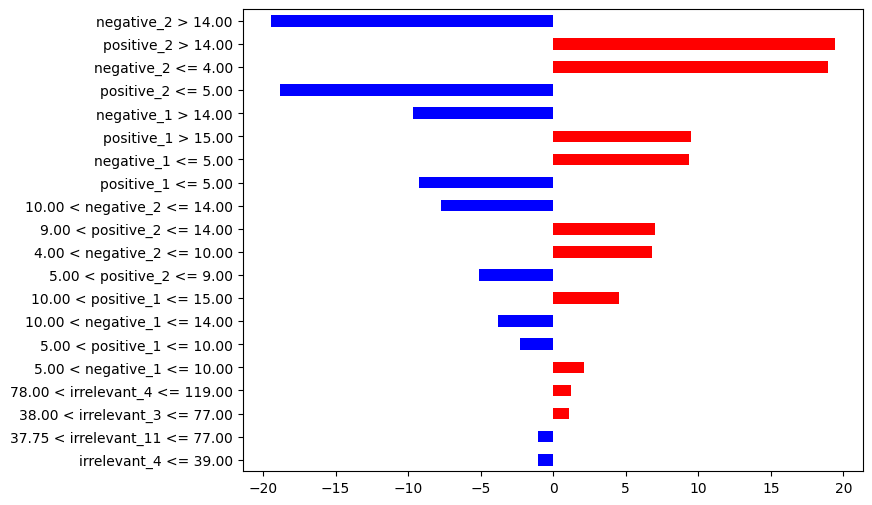

In [ ]:
# Summarize the Effects of All Features using SubmodularPick
submodular_explainer = submodular_pick.SubmodularPick(explainer, X_train, model.predict, sample_size=20, num_features=10, num_exps_desired=5)
df_explainer = pd.DataFrame([dict(explain.as_list()) for explain in submodular_explainer.explanations])
df_describe = df_explainer.describe()
index_list = list(df_describe.index)
df_describe.loc[8] = abs(df_describe.iloc[5])
df_describe.index = index_list+['abs(50%)']
df_describe = df_describe.sort_values(by='abs(50%)', axis=1, ascending=False)
df_describe = df_describe[df_describe.columns[:20]].T
df_describe = df_describe.iloc[::-1]
df_describe['positive'] = df_describe['50%'] > 0
df_describe.plot(y='50%',kind="barh", color=df_describe['positive'].map({True: 'r', False: 'b'}), legend=None, figsize=(8, 6))
plt.show()

LIME can also explain the direction and magnitude of influence on ***all*** predictions with submodular pick.

### [6] SHAP Explanation

Using the same synthetic dataset, in this section we will employ SHAP to help interpret our results.

In [ ]:
# Call SHAP Explainer Function
explainer = shap.Explainer(model,feature_names=df_feature.columns)
shap_values = explainer(X_test)

[23:49:39] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


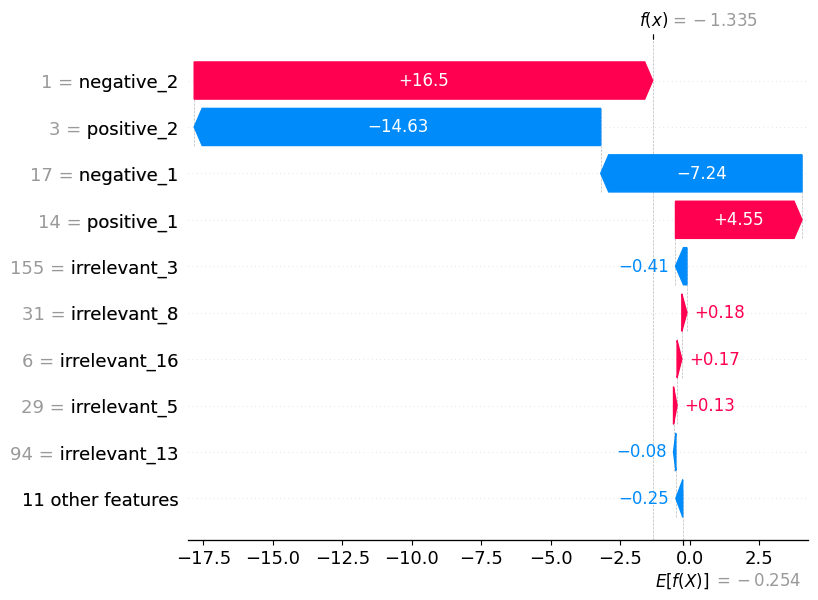

In [ ]:
# Visualize the First Prediction's Explanation
shap.plots.waterfall(shap_values[0])

SHAP can explain the direction and magnitude of influence on a single point. In this visualization, we will estimate the influence of the first prediction, which we also used in the LIME section.

In [ ]:
# Visualize the First Prediction's Explanation with Force Plot
shap.initjs()
shap.plots.force(shap_values[0])

In the above visualization, SHAP attempts to explain the direction and magnitude of influence on first prediction in a different visual perspective.

In [ ]:
# Visualize Training Set Predictions
shap.initjs()
shap.plots.force(shap_values)

In the above plot, SHAP interactively explains the direction and magnitude of influence on the training data set.

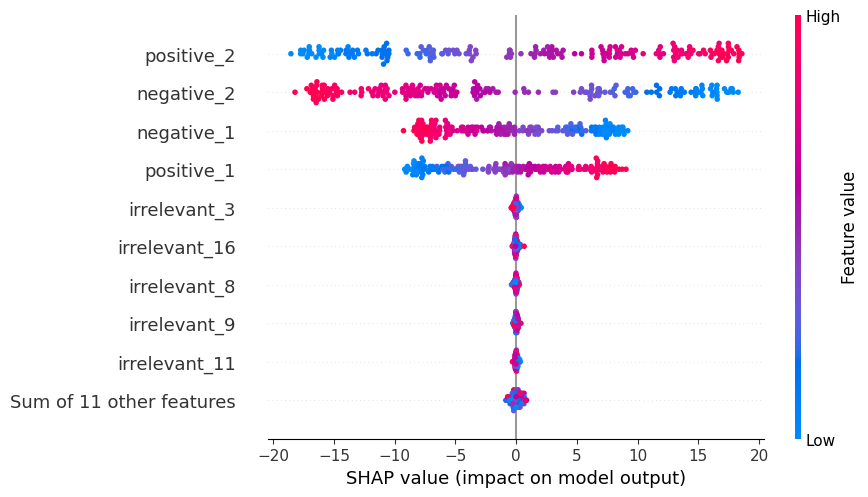

In [ ]:
# Summarize Effects of All Features
shap.initjs()
shap.plots.beeswarm(shap_values)

In the above visualization, SHAP attempts to explain the direction and magnitude of influence on ***all*** predictions.

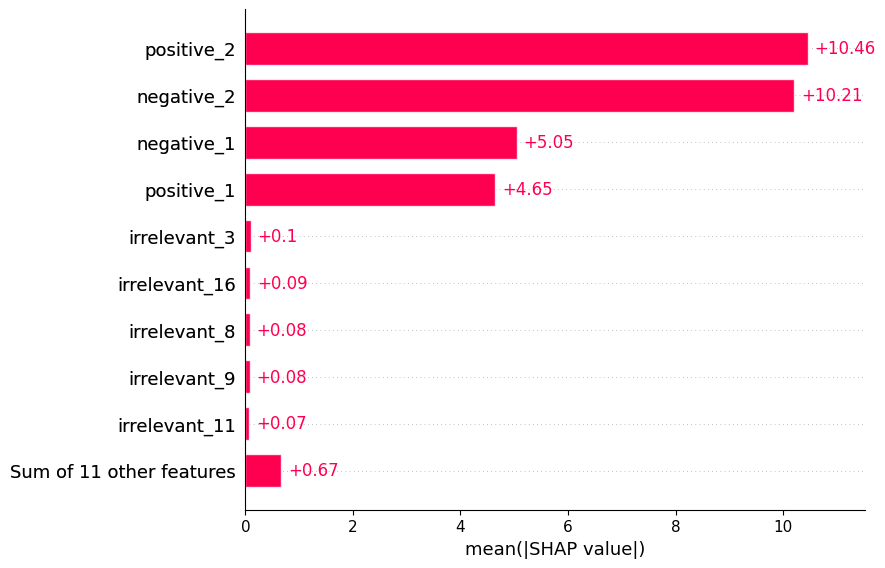

In [ ]:
# Summarize Average Effects of Features
shap.initjs()
shap.plots.bar(shap_values)

In this final chart, SHAP attempts to explain the magnitude of influence on all predictions.

# Reflections

There are multiple methods you could employ to aid in interpreting the results of your ML models. We only covered a few in this tutorial, but there are many others available that can be used depending on your ML model. This includes the following (but not limited to):


*   ELi5 (Explain Like I'm 5): https://github.com/TeamHG-Memex/eli5
*   Shapash: https://github.com/MAIF/shapash
*   Anchor: https://github.com/marcotcr/anchor
*   AIX360: https://github.com/Trusted-AI/AIX360

